In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import seaborn as sn
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
import lifelines
import models
import torch
from pycox.models import DeepHitSingle
import warnings
import utils

import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from ray import tune
pd.set_option('display.max_columns', None)


In [3]:
df = utils.get_unprocessed_dataset()[0]
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,YES,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,0:LIVING,Negative,YES,138.65,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,YES,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,0:LIVING,Positive,YES,83.52,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,YES,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,1:DECEASED,Positive,NO,151.28,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,YES,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,0:LIVING,Positive,YES,162.76,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,YES,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,1:DECEASED,Positive,YES,18.55,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


## Test set

In [4]:
df_clear, event_col, duration_col = utils.get_processed_dataset()
df_train, df_test = utils.split_dataset(df_clear)
df_train

,Age at Diagnosis,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Tumor Size,Tumor Stage,Censorship,Type of Breast Surgery_MASTECTOMY,Cellularity_Low,Cellularity_Moderate,Chemotherapy_YES,Pam50 + Claudin-low subtype_Basal,Pam50 + Claudin-low subtype_Her2,Pam50 + Claudin-low subtype_LumA,Pam50 + Claudin-low subtype_LumB,Pam50 + Claudin-low subtype_Normal,Pam50 + Claudin-low subtype_claudin-low,ER status measured by IHC_Positve,ER Status_Positive,HER2 status measured by SNP6_GAIN,HER2 status measured by SNP6_LOSS,HER2 status measured by SNP6_NEUTRAL,HER2 Status_Positive,Hormone Therapy_YES,Inferred Menopausal State_Pre,Integrative Cluster_10,Integrative Cluster_2,Integrative Cluster_3,Integrative Cluster_4ER+,Integrative Cluster_4ER-,Integrative Cluster_5,Integrative Cluster_6,Integrative Cluster_7,Integrative Cluster_8,Integrative Cluster_9,Primary Tumor Laterality_Right,PR Status_Positive,Radio Therapy_YES,3-Gene classifier subtype_ER+/HER2- Low Prolif,3-Gene classifier subtype_ER-/HER2-,3-Gene classifier subtype_HER2+
1,43.19,1.0,3.0,0.0,2.0,4.020,84.633333,10.0,1.0,True,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
4,76.97,1.0,3.0,8.0,2.0,6.080,41.366667,40.0,2.0,False,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0
5,78.77,1.0,3.0,0.0,4.0,4.062,7.800000,31.0,4.0,False,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
11,84.22,1.0,2.0,0.0,5.0,3.056,36.266667,28.0,2.0,False,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12,85.49,1.0,2.0,0.0,1.0,3.044,132.033333,22.0,4.0,False,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,71.22,5.0,2.0,4.0,11.0,5.060,85.000000,30.0,2.0,False,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
1698,70.65,5.0,1.0,0.0,9.0,2.040,201.166667,20.0,1.0,True,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0
1700,75.62,5.0,3.0,0.0,4.0,4.040,105.200000,20.0,1.0,False,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1702,52.84,5.0,2.0,6.0,5.0,5.040,200.333333,20.0,2.0,True,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0


<AxesSubplot: >

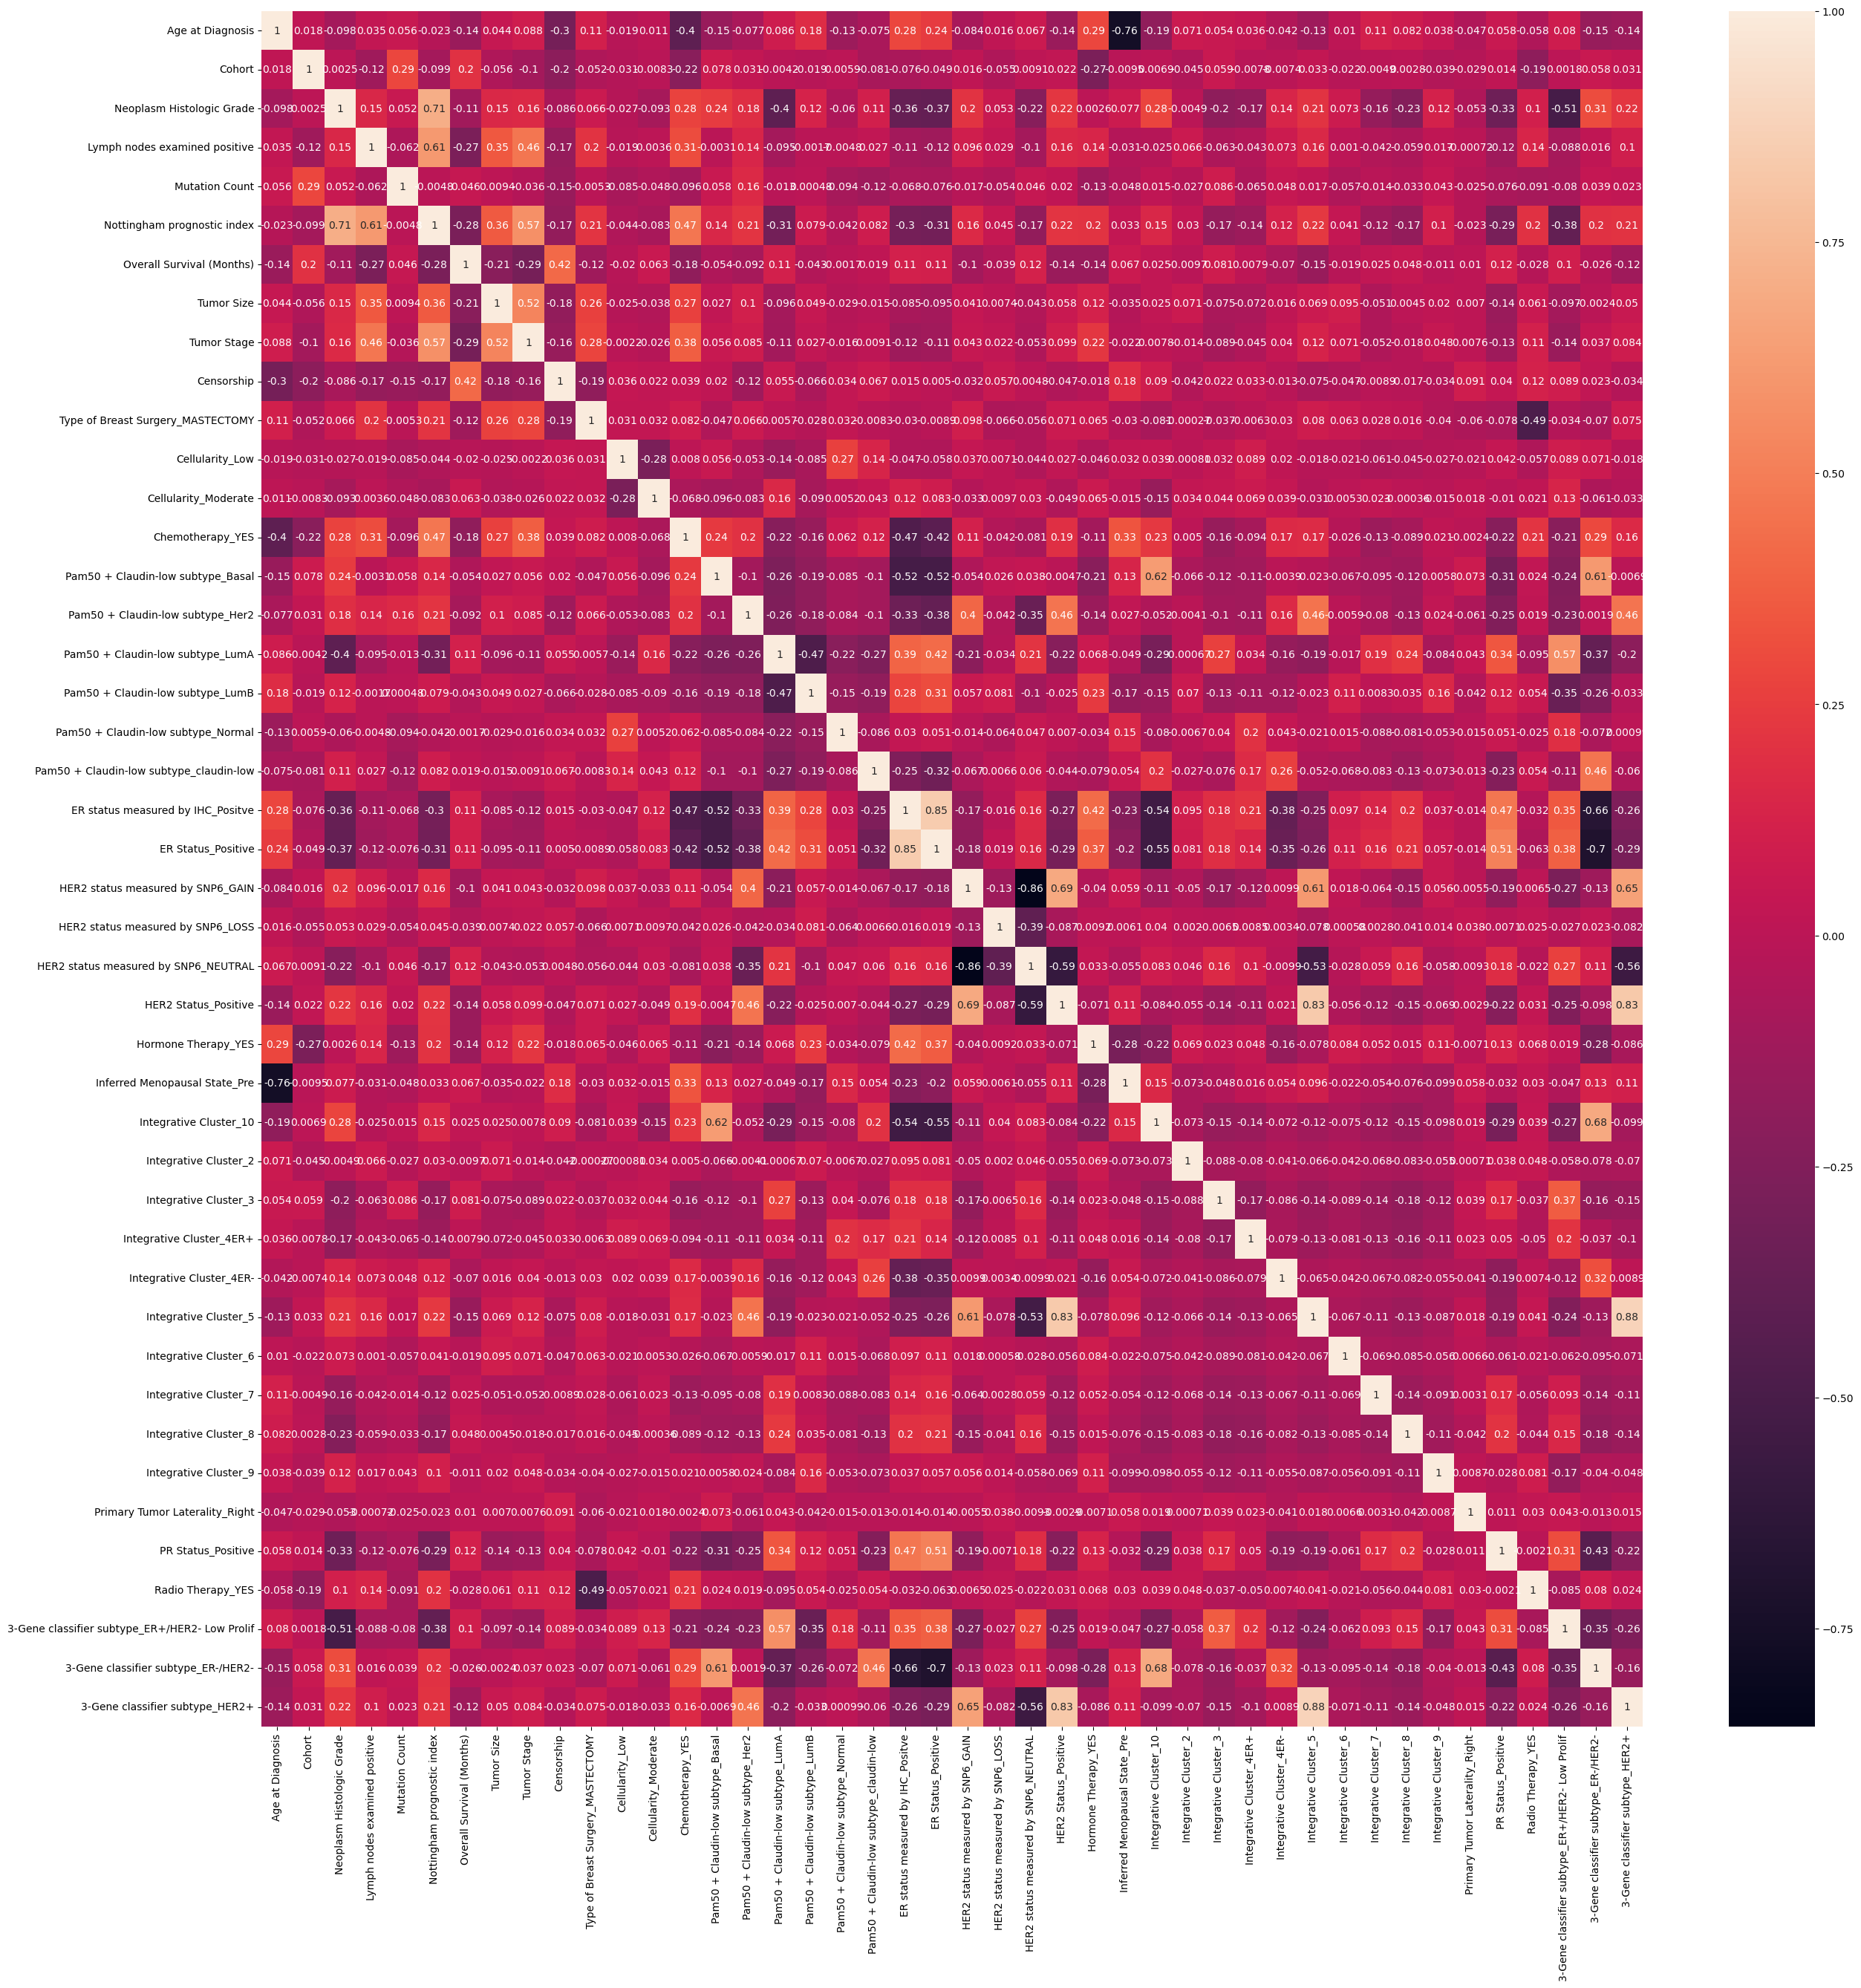

In [5]:
plt.figure(figsize=(30, 30))
sn.heatmap(df_train.corr(), annot=True)

In [6]:
X = df_train.drop([event_col, duration_col], axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                                           feature         VIF
0                                 Age at Diagnosis   60.484583
1                                           Cohort    8.425115
2                        Neoplasm Histologic Grade   63.060122
3                    Lymph nodes examined positive    2.873118
4                                   Mutation Count    3.579849
5                      Nottingham prognostic index  117.371390
6                                       Tumor Size    5.905703
7                                      Tumor Stage   20.461059
8                Type of Breast Surgery_MASTECTOMY    4.163626
9                                  Cellularity_Low    1.496714
10                            Cellularity_Moderate    1.952794
11                                Chemotherapy_YES    2.769295
12               Pam50 + Claudin-low subtype_Basal   36.182192
13                Pam50 + Claudin-low subtype_Her2   33.497690
14                Pam50 + Claudin-low subtype_LumA  145

In [7]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)
mean_concordance = 0.0
models = []
oof_preds = np.zeros((len(df_train), 1))
for i, (train_index, test_index) in enumerate(kf.split(df_train)):
    train = df_train.iloc[train_index]
    valid = df_train.iloc[test_index]

    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(train, duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(valid, scoring_method="concordance_index")

    print("Fold: ", i, "concordance index: ", concordance_index)
    
    mean_concordance += concordance_index

    oof_preds[test_index] = cph.predict_partial_hazard(valid).values.reshape(-1, 1)

    models.append(cph)
print("oof concordance index: ", lifelines.utils.concordance_index(df_train[duration_col].values, -oof_preds, df_train[event_col].values))


Fold:  0 concordance index:  0.8201438848920863
Fold:  1 concordance index:  0.6385625431928127
Fold:  2 concordance index:  0.8076588337684943
Fold:  3 concordance index:  0.7034632034632035
Fold:  4 concordance index:  0.6744366744366744
Fold:  5 concordance index:  0.6435185185185185
Fold:  6 concordance index:  0.6382322713257965
Fold:  7 concordance index:  0.6694701429772918
Fold:  8 concordance index:  0.685625
Fold:  9 concordance index:  0.6725925925925926
oof concordance index:  0.705028621466911


In [8]:
cph = CoxPHFitter(penalizer=0.01)
cph.fit(train, duration_col = duration_col, event_col = event_col)
concordance_index = cph.score(valid, scoring_method="concordance_index")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 787 total observations, 438 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Censorship'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 787
number of events observed = 349
   partial log-likelihood = -1737.98
         time fit was run = 2023-04-25 15:17:09 UTC

---
                                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                              
Age at Diagnosis                                -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
Cohort                                          -0.61       0.54       0.08            -0.77            -0.45                 0.46                 0.64
Neoplasm Histologic Grade                        0.30       1.35       0.17            -0.04             0.64                 0.97                 1.90
Lymph nodes examined positive                    0.02       1.02       0.03            -0.04             0.08                 0.96                 1.09
Mutation Count                                  -0.06       0.94       0.02            -0.10            -0.02                 0.91                 0.98
Nottingham prognostic index                     -0.33       0.72       0.14            -0.62            -0.05                 0.54                 0.95
Tumor Size                                      -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
Tumor Stage                                      0.21       1.24       0.14            -0.07             0.49                 0.94                 1.64
Type of Breast Surgery_MASTECTOMY               -0.32       0.72       0.15            -0.62            -0.03                 0.54                 0.97
Cellularity_Low                                  0.27       1.31       0.19            -0.11             0.64                 0.90                 1.91
Cellularity_Moderate                            -0.04       0.96       0.13            -0.28             0.21                 0.75                 1.23
Chemotherapy_YES                                 0.47       1.60       0.20             0.08             0.86                 1.08                 2.36
Pam50 + Claudin-low subtype_Basal               -0.22       0.80       0.47            -1.14             0.70                 0.32                 2.01
Pam50 + Claudin-low subtype_Her2                -0.59       0.55       0.49            -1.55             0.37                 0.21                 1.44
Pam50 + Claudin-low subtype_LumA                 0.03       1.03       0.41            -0.78             0.84                 0.46                 2.31
Pam50 + Claudin-low subtype_LumB                 0.14       1.15       0.42            -0.69             0.97                 0.50                 2.64
Pam50 + Claudin-low subtype_Normal               0.23       1.26       0.45            -0.66             1.12                 0.52                 3.05
Pam50 + Claudin-low subtype_claudin-low         -0.43       0.65       0.45            -1.31             0.45                 0.27                 1.56
ER status measured by IHC_Positve               -0.20       0.82       0.34            -0.86             0.46                 0.42                 1.59
ER Status_Positive                              -0.81       0.44       0.33            -1.45            -0.17                 0.23                 0.84
HER2 status measured by SNP6_GAIN                0.06       1.06       0.56            -1.03             1.15                 0.36                 3.16
HER2 status measured by SNP6_LOSS                0.35  

In [9]:
predictions = np.zeros(df_test.shape[0])
for model in models:
    predictions -= model.predict_partial_hazard(df_test)
predictions /= num_folds
lifelines.utils.concordance_index(df_test[duration_col], predictions, event_observed=df_test[event_col])

0.65

In [10]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)


TIME_BINS = 20

oof_preds_surv = np.zeros((df_train.shape[0], 1))
oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))

for i, (train_index, test_index) in enumerate(kf.split(df_train)):

    train = df_clear.iloc[train_index]
    valid = df_clear.iloc[test_index]

    model = SurvModel(df_train.copy(), events_col=event_col, time_col=duration_col)
    
    history_surv = model.fit(epochs=300, lr=0.01, verbose=False, train_index=train_index, valid_index=test_index)
    oof_preds_surv[test_index] = model.predict(test_index)
    #utils.plot_history(history_surv, 'SurvModel')

    hit_model = DeepHitModel(df_train.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=10, layers = [64, 128, 64, 16], dropout=0.4)
    history_hit = hit_model.fit(epochs=300, train_index=train_index, valid_index=test_index, lr=0.01, verbose=False)



    oof_preds_hit[test_index] = hit_model.predict(test_index)
    #utils.plot_history(history_hit, 'DeepHit')

    num_durations = 10
    labtrans = DeepHitSingle.label_transform(num_durations)

    x = train.drop([event_col, duration_col], axis=1).values.astype('float32')
    y = labtrans.fit_transform(train[duration_col].values, train[event_col].values)
    
    val_x = valid.drop([event_col, duration_col], axis=1).values.astype('float32')
    val_y = labtrans.fit_transform(valid[duration_col].values, valid[event_col].values)


    in_features = x.shape[1]
    num_nodes = [64, 32, 16]
    out_features = num_durations
    batch_norm = True
    dropout = 0.1
    output_bias = False
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias = output_bias).float()

    m = DeepHitSingle(net, tt.optim.Adam)
    m.optimizer.set_lr(0.01)
    log = m.fit(x, y, batch_size=256, epochs=50, verbose=False)

    surv = m.predict_surv_df(val_x)
    ev = EvalSurv(surv, val_y[0], val_y[1], censor_surv='km')

    print(f'Fold {i}')
    #print(f'loss {losses.negative_likelihood_loss(valid_preds, torch.tensor(valid[duration_col].values, dtype=torch.float))}') 
    print(f'package concordance {ev.concordance_td("antolini")}, surv concordance {np.max(history_surv["val_c_index"])}, hit concordance {np.max(history_hit["val_c_index"])}')

hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), range(0, oof_preds_hit.shape[0]))
surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), range(0, oof_preds_surv.shape[0]))
print(f'oof concordance, hit {hit_oof}, surv {surv_oof} ')

Fold 0
package concordance 0.7539863325740319, surv concordance 0.712318286151492, hit concordance 0.7258193445243805
Fold 1
package concordance 0.7597200622083982, surv concordance 0.768595041322314, hit concordance 0.7671043538355218
Fold 2
package concordance 0.7825704225352113, surv concordance 0.7452681388012619, hit concordance 0.7980852915578764
Fold 3
package concordance 0.8266009852216749, surv concordance 0.7812982998454405, hit concordance 0.7647907647907648
Fold 4
package concordance 0.7470489038785835, surv concordance 0.6229641693811075, hit concordance 0.6752136752136753
Fold 5
package concordance 0.6382488479262672, surv concordance 0.7285291214215203, hit concordance 0.7160493827160493
Fold 6
package concordance 0.6648168701442841, surv concordance 0.7780429594272077, hit concordance 0.6916752312435765
Fold 7
package concordance 0.7025316455696202, surv concordance 0.7942681678607983, hit concordance 0.7283431455004206
Fold 8
package concordance 0.7818791946308725, sur

In [14]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

def train_hit(config):

    TIME_BINS = config["time_bins"]
    oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))

    for i, (train_index, test_index) in enumerate(kf.split(df_train)):

        train = df_clear.iloc[train_index]
        valid = df_clear.iloc[test_index]
        

        hit_model = DeepHitModel(df_train.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=config["interpolation_steps"]
                                 , layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"])
        hit_model.fit(epochs=300, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, weight_decay=config["weight_decay"])
        oof_preds_hit[test_index] = hit_model.predict(test_index)
        

    hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), range(0, oof_preds_hit.shape[0]))
    hit_oof_loss = losses.deep_hit_loss(torch.tensor(oof_preds_hit), hit_model.mask).detach().numpy()
    tune.report(loss = hit_oof_loss, c_index=hit_oof)

def train_surv(config):
        oof_preds_surv = np.zeros((df_train.shape[0], 1))
    
        for i, (train_index, test_index) in enumerate(kf.split(df_train)):
    
            train = df_clear.iloc[train_index]
            valid = df_clear.iloc[test_index]
    
            model = SurvModel(df_train.copy(), events_col=event_col, time_col=duration_col, layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"])
            model.fit(epochs=300, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, weight_decay=config["weight_decay"])
            
            oof_preds_surv[test_index] = model.predict(test_index)
    
        surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), range(0, oof_preds_surv.shape[0]))
        surv_oof_loss = losses.negative_likelihood_loss(torch.tensor(oof_preds_surv), torch.tensor(model.events, dtype=torch.float)).detach().numpy()
        tune.report(loss = surv_oof_loss, c_index=surv_oof)

hit_config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64, 128]),
    "num_layers": tune.choice([3, 4, 5, 6, 7, 8]),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "time_bins": tune.choice([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]),
    "interpolation_steps": tune.choice([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
}

surv_config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64, 128]),
    "num_layers": tune.choice([3, 4, 5, 6, 7, 8]),
    "weight_decay": tune.loguniform(1e-4, 1e-1)
}



In [12]:
analysis_hit = tune.run(
    train_hit,
    config=hit_config,
    num_samples=100,
    resources_per_trial={"cpu": 1, "gpu": 0},
    metric="c_index",
    mode="max",
    name="hit",
    local_dir="~/ray_results"
)
print(f'best score{analysis_hit.get_best_trial(metric="c_index", mode="max").last_result["c_index"]}, best config {analysis_hit.get_best_trial(metric="c_index", mode="max").config}')

2023-04-25 17:20:21,059	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,c_index,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_hit_b2a3a_00000,0.509559,2023-04-25_17-30-13,True,,d39ab6fb04104af2a6c6694fe11bbcdf,"0_dropout=0.1415,interpolation_steps=30,layer_size=32,lr=0.0002,num_layers=8,time_bins=100,weight_decay=0.0004",DESKTOP-670FM4Q,1,2.2567,127.0.0.1,28676,583.695,583.695,583.695,1682436613,0,,1,b2a3a_00000,0.00699759
train_hit_b2a3a_00001,0.664521,2023-04-25_17-25-15,True,,9f29a1bfaffb4d428dc47b70bbe01697,"1_dropout=0.3472,interpolation_steps=45,layer_size=16,lr=0.0172,num_layers=6,time_bins=20,weight_decay=0.0551",DESKTOP-670FM4Q,1,1.39406,127.0.0.1,17332,279.608,279.608,279.608,1682436315,0,,1,b2a3a_00001,0.00499916
train_hit_b2a3a_00002,0.5507,2023-04-25_17-31-03,True,,d85455964bd14c6fa51b456ecb4e2b06,"2_dropout=0.1316,interpolation_steps=40,layer_size=64,lr=0.0002,num_layers=5,time_bins=50,weight_decay=0.0006",DESKTOP-670FM4Q,1,1.9421,127.0.0.1,29344,621.058,621.058,621.058,1682436663,0,,1,b2a3a_00002,0.00499892
train_hit_b2a3a_00005,0.694812,2023-04-25_17-26-19,True,,e7e92e5095aa465f9b90fbc0d631f3ce,"5_dropout=0.3629,interpolation_steps=20,layer_size=128,lr=0.0707,num_layers=3,time_bins=40,weight_decay=0.0030",DESKTOP-670FM4Q,1,1.73448,127.0.0.1,21480,315.823,315.823,315.823,1682436379,0,,1,b2a3a_00005,0.00699997
train_hit_b2a3a_00006,0.472781,2023-04-25_17-26-59,True,,39d8c4fb4c0f42838fdf58a1294603df,"6_dropout=0.4190,interpolation_steps=10,layer_size=16,lr=0.0025,num_layers=6,time_bins=100,weight_decay=0.0003",DESKTOP-670FM4Q,1,2.16937,127.0.0.1,3016,339.867,339.867,339.867,1682436419,0,,1,b2a3a_00006,0.036001
train_hit_b2a3a_00010,0.699556,2023-04-25_17-28-49,True,,6f743733bc604c598a558be021b716b7,"10_dropout=0.3635,interpolation_steps=30,layer_size=32,lr=0.0136,num_layers=3,time_bins=30,weight_decay=0.0987",DESKTOP-670FM4Q,1,1.55629,127.0.0.1,11636,358.331,358.331,358.331,1682436529,0,,1,b2a3a_00010,0.0519986
train_hit_b2a3a_00011,0.603337,2023-04-25_17-28-14,True,,8eb0d593dee340dda7f0cf498507c0ef,"11_dropout=0.2755,interpolation_steps=20,layer_size=128,lr=0.0146,num_layers=4,time_bins=70,weight_decay=0.0249",DESKTOP-670FM4Q,1,2.06008,127.0.0.1,36800,286.393,286.393,286.393,1682436494,0,,1,b2a3a_00011,0.0530012
train_hit_b2a3a_00016,0.546265,2023-04-25_17-28-30,True,,9f29a1bfaffb4d428dc47b70bbe01697,"16_dropout=0.1427,interpolation_steps=5,layer_size=64,lr=0.0723,num_layers=7,time_bins=70,weight_decay=0.0027",DESKTOP-670FM4Q,1,2.04929,127.0.0.1,17332,165.689,165.689,165.689,1682436510,0,,1,b2a3a_00016,0.00499916


2023-04-25 18:24:04,756	INFO tune.py:798 -- Total run time: 3821.68 seconds (3821.58 seconds for the tuning loop).


best score0.735555483483873, best config {'lr': 0.053876851874671436, 'dropout': 0.12421230856433746, 'layer_size': 16, 'num_layers': 5, 'weight_decay': 0.0008190026249514021, 'time_bins': 10, 'interpolation_steps': 40}


In [15]:
analysis_surv = tune.run(
    train_surv,
    config=surv_config,
    num_samples=100,
    resources_per_trial={"cpu": 1, "gpu": 0},
    metric="c_index",
    mode="max",
    name="surv",
    local_dir="~/ray_results"
)
print(f'best score{analysis_surv.get_best_trial(metric="c_index", mode="max").last_result["c_index"]}, best config {analysis_surv.get_best_trial(metric="c_index", mode="max").config}')

2023-04-25 19:44:49,163	WARNING tensorboardx.py:224 -- You are trying to log an invalid value (ray/tune/loss=nan) via TBXLoggerCallback!
2023-04-25 19:44:49,163	WARNING tensorboardx.py:224 -- You are trying to log an invalid value (ray/tune/loss=nan) via TBXLoggerCallback!
2023-04-25 19:55:46,496	INFO tune.py:798 -- Total run time: 1135.27 seconds (1135.21 seconds for the tuning loop).


best score0.752331068480711, best config {'lr': 0.02905715756516051, 'dropout': 0.2699240753578376, 'layer_size': 128, 'num_layers': 5, 'weight_decay': 0.0017288863999162358}
